## PROJECT 32: Population Time Series Data

> ### TASK: Stady dense neural network for forecasting time series


### Project goals and objectives

#### Project goal

- Studying **Dense neural network for forecasting time series**

#### Project objectives

1. Explore and prepare data 
2. Building several dense models

### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
sns.set_style('whitegrid')

import re
import math as math

import tensorflow as tf

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteScaledError


from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### LOAD DATA

In [2]:
# Path to data
data_path = "data/POP.csv"

In [3]:
# Load the data
train_df = pd.read_csv(data_path, parse_dates=['date'], index_col=['date'])

# Check result 
train_df.head()

,realtime_start,value,realtime_end
date,,,
1952-01-01,2019-12-06,156309.0,2019-12-06
1952-02-01,2019-12-06,156527.0,2019-12-06
1952-03-01,2019-12-06,156731.0,2019-12-06
1952-04-01,2019-12-06,156943.0,2019-12-06
1952-05-01,2019-12-06,157140.0,2019-12-06


In [4]:
# Drop columns
train_df.drop(["realtime_start", "realtime_end"], axis=1,inplace=True)

# Check result 
train_df.head()

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


### EXPLORATORY DATA ANALYSIS 

In [5]:
# Check the missing values
print("Check the number of records")
print("Number of records: ", train_df.shape[0], "\n")

print("Null analysis")
empty_sample = train_df[train_df.isnull().any(axis=1)]
print("Number of records contain 1+ null: ", empty_sample.shape[0], "\n")

Check the number of records
Number of records:  816 

Null analysis
Number of records contain 1+ null:  0 



In [6]:
train_df.shape

(816, 1)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 816 entries, 1952-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   816 non-null    float64
dtypes: float64(1)
memory usage: 12.8 KB


#### Distribution analysis

In [8]:
def distribution(data_for_eda):
    
    fig, ax = plt.subplots(1,3, figsize=(25, 5))
    fig.subplots_adjust(wspace=0.15)
    plt.suptitle("Distribution of observations", fontsize=18)
    
    sns.set_style("whitegrid")
    sns.histplot(data = data_for_eda, bins = 20, stat = 'density', kde = False, ax=ax[0])
    sns.boxenplot(data = data_for_eda, ax=ax[1])
    sns.ecdfplot(data = data_for_eda, ax=ax[2])
    
    fig, ax = plt.subplots(1,1, figsize=(25, 5))
    plt.plot(data_for_eda)
    plt.title("Montly Value", fontsize=18)
    
    print("Descriptive statistics:\n{}\n".format(data_for_eda.describe().round(2)) + '_' * 100+ '\n')
    print("Skew:\n{}\n".format(data_for_eda.skew().round(2))+ '_' * 100+ '\n')
    print("Kurtosis:\n{}\n".format(data_for_eda.kurt().round(2)) + '_' * 100+ '\n')

Descriptive statistics:
           value
count     816.00
mean   243847.77
std     50519.14
min    156309.00
25%    201725.25
50%    239557.50
75%    289364.25
max    330309.95
____________________________________________________________________________________________________

Skew:
value    0.08
dtype: float64
____________________________________________________________________________________________________

Kurtosis:
value   -1.19
dtype: float64
____________________________________________________________________________________________________



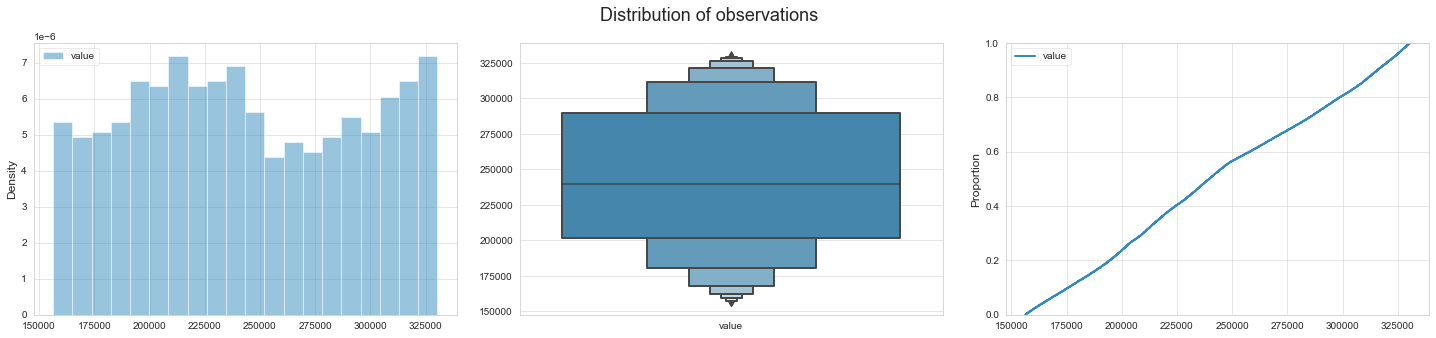

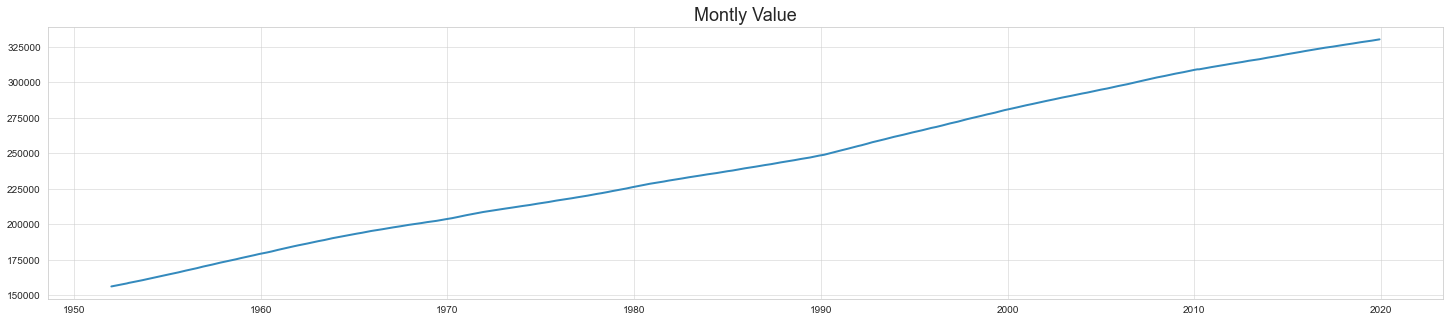

In [9]:
distribution(train_df)

#### Trend analysis

In [10]:
def trend_analysis(data_for_eda):
    # BUILDING MOVING AVERAGES
    
    # 7-day moving average
    data_7d_rol = data_for_eda.rolling(window = 7, center = True).mean()

    # 30-day moving average
    data_30d_rol = data_for_eda.rolling(window = 30, center = True).mean()

    # 365-day moving average
    data_365d_rol = data_for_eda.rolling(window = 365, center = True).mean()
    
    #PLOTTING MOVING AVERAGES
    
    fig, ax = plt.subplots(figsize = (20,5))

    # plotting daily data
    ax.plot(data_for_eda, marker='*', markersize=2, color='0.6',linestyle='None', label='Daily')

    # A fallback version of the presentation
    # ax.plot(novaya_entering_t2, linewidth=2, label='Daily', color='0.6', alpha = 0.5 )

    # plotting 7-day rolling data
    ax.plot(data_7d_rol, linewidth=2, label='7-d Rolling Mean')

    # plotting 30-day rolling data
    ax.plot(data_30d_rol, linewidth=2, label='30-d Rolling Mean')

    # plotting annual rolling data
    ax.plot(data_365d_rol, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean)')

        
    # Beautification of plot
    # ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('People')
    ax.set_title('Trends in series', fontsize=18)

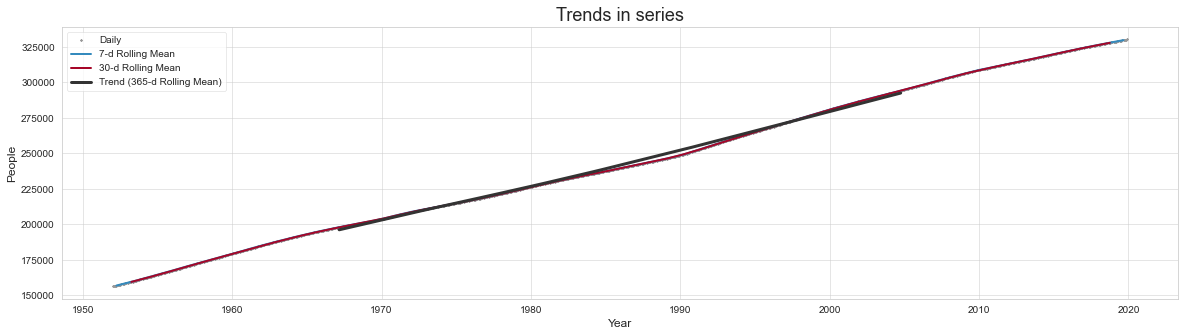

In [11]:
trend_analysis(train_df)

#### Autocorrelation analysis

In [12]:
def autocorr_analysis(data_for_eda):
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 3), dpi= 100)
    plt.suptitle("Autocorrelation analysis", fontsize=18)
    
    sm.graphics.tsa.plot_acf(data_for_eda.values.squeeze(), lags=50, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data_for_eda.values.squeeze(), lags=50, ax=ax[1])
    plt.show()

    fig, ax = plt.subplots(figsize=(19.7, 3), dpi= 100)
    pd.plotting.autocorrelation_plot(data_for_eda, ax=ax)
    plt.show()

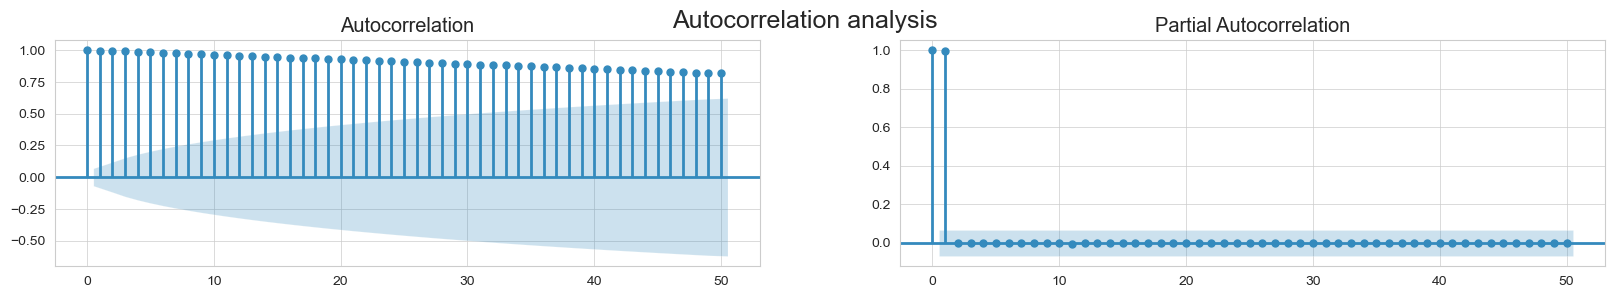

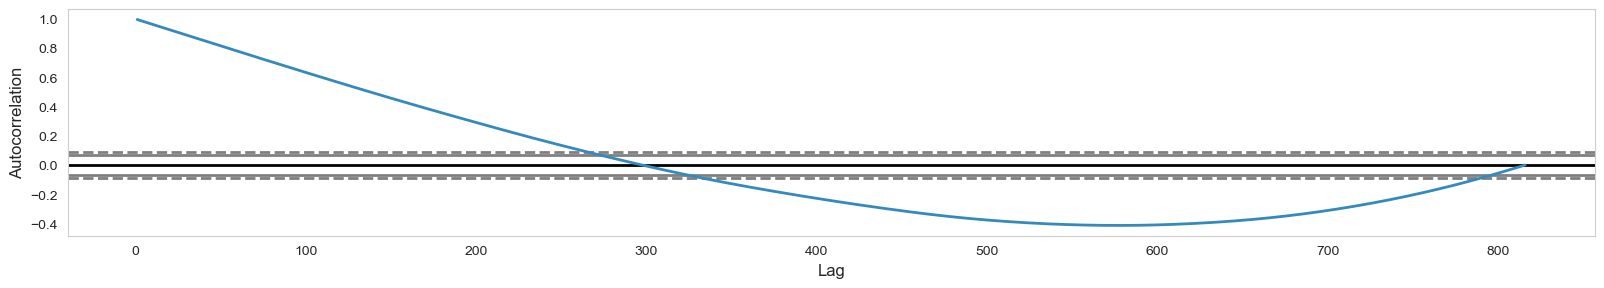

In [13]:
autocorr_analysis(train_df)

#### Analysis of seasonality

In [14]:
def seasonality_analysis(data_for_eda, period=365):
    seasonality = sm.tsa.seasonal_decompose(data_for_eda, model='additive', period=period).seasonal
    fig, ax = plt.subplots(figsize = (20,5))
    ax.plot(seasonality)          

In [15]:
def decomposition(data_for_eda):
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,5
        
    decomposition = sm.tsa.seasonal_decompose(data_for_eda, model='additive')
    
    decomposition.plot()
    plt.suptitle("Decomposition", fontsize=18)

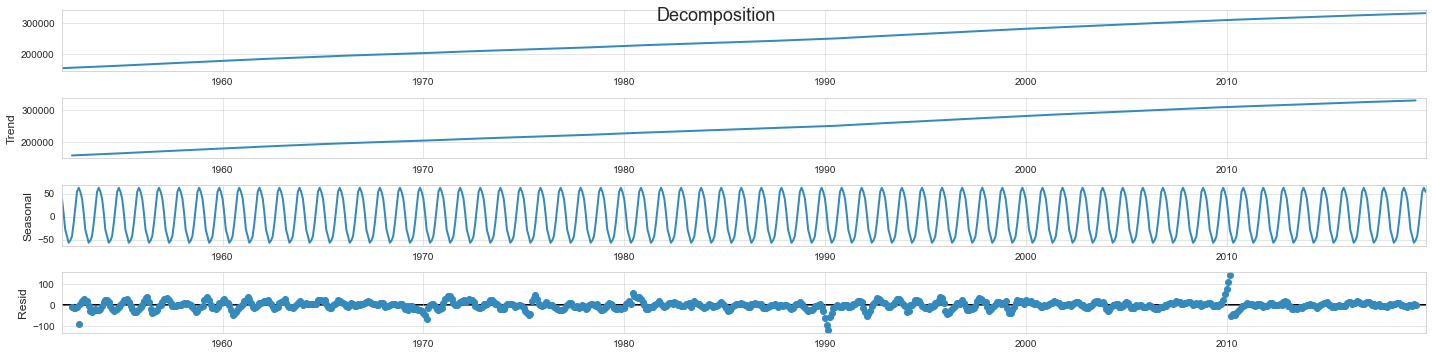

In [16]:
decomposition(train_df)

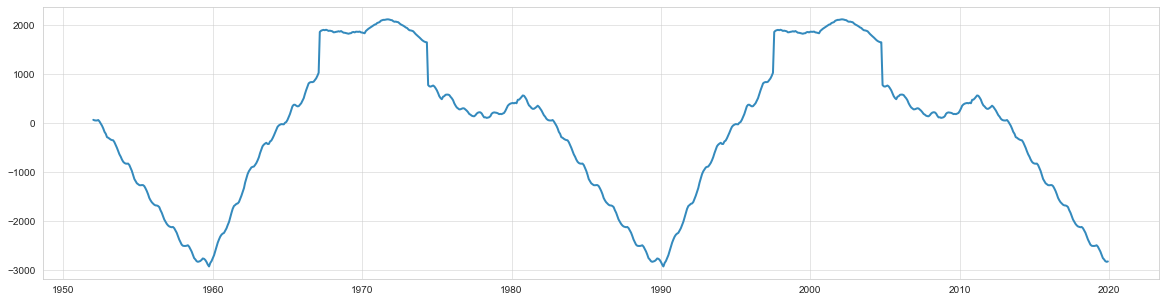

In [17]:
seasonality_analysis(train_df, period=365)

#### Analysis of stationarity

In [18]:
def stationarity_analysis(data_for_eda):
    test = sm.tsa.adfuller(data_for_eda)
    print ('adf:', test[0])
    print ('p-value:', test[1])
    print ('Critical values:', test[4])
    if test[0]> test[4]['5%']: 
        print ('\n There are single roots, the row is not stationary')
    else:
        print ('\n There are no single roots, the row is STATIONARY')

In [19]:
stationarity_analysis(train_df)

adf: -0.6653174110244149
p-value: 0.8555297778919547
Critical values: {'1%': -3.4385711275998583, '5%': -2.8651686574447375, '10%': -2.568702230639255}

 There are single roots, the row is not stationary


### DATA PREPARATION 

#### Split the dataset into train and test sets

In [20]:
y_train, y_test = temporal_train_test_split(train_df, 
                                            test_size=0.2)

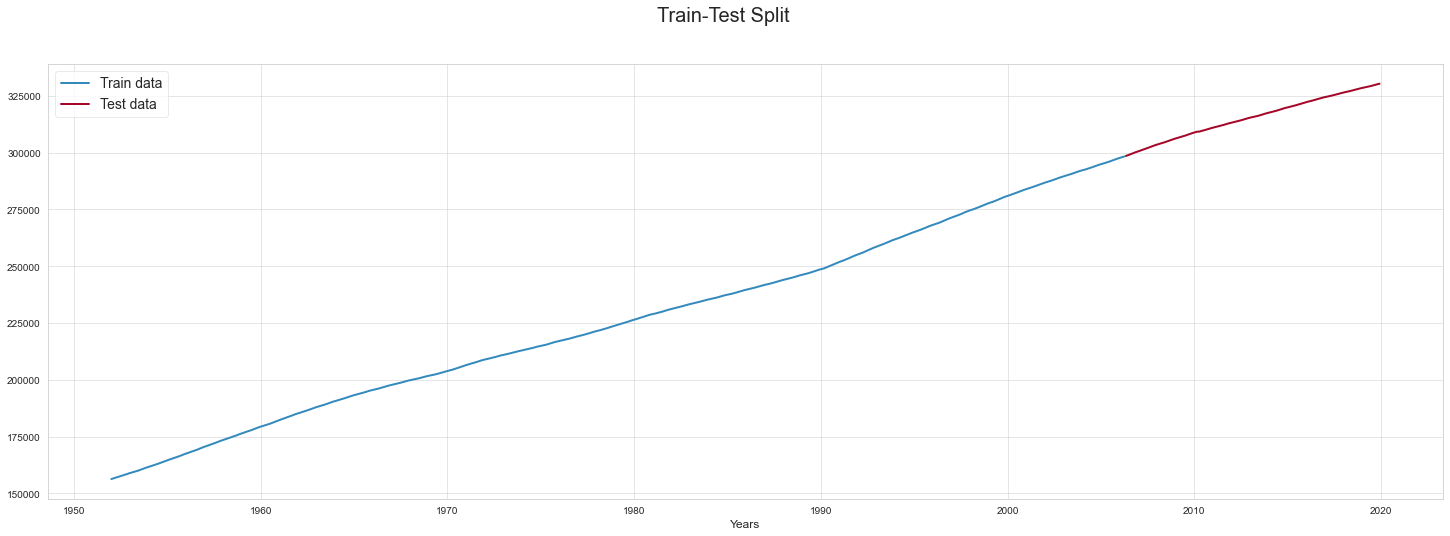

In [21]:
plt.figure(figsize=(25,8))
plt.suptitle('Train-Test Split', fontsize=20)
plt.plot(y_train, label="Train data")
plt.plot(y_test, label="Test data")
plt.xlabel("Years")
plt.legend(fontsize=14, loc='upper left')
plt.show();

In [22]:
print(y_train.shape)
print(y_test.shape)
print('Number of features = '+str(y_train.shape[1]))
print('Number of train instances = '+str(y_train.shape[0]))
print('Number of test instances = '+str(y_test.shape[0]))

(652, 1)
(164, 1)
Number of features = 1
Number of train instances = 652
Number of test instances = 164


In [23]:
# Forecasting horizon
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2006-05-01', '2006-06-01', '2006-07-01', '2006-08-01',
               '2006-09-01', '2006-10-01', '2006-11-01', '2006-12-01',
               '2007-01-01', '2007-02-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=164, freq=None, is_relative=False)

#### Slid window

In [24]:
cutoff = pd.Period("2006-05", freq="M")

In [25]:
fh.to_relative(cutoff)

AssertionError: 

In [26]:
WINDOW_LENGTH = 30
FORECASTING_HORIZON = fh

slid_window  = SlidingWindowSplitter(window_length=WINDOW_LENGTH, fh=FORECASTING_HORIZON)

In [27]:
n_splits = slid_window.get_n_splits(y_train)
print(f"Number of Folds = {n_splits}")

ValueError: `fh` must be relative, but found absolute `fh`